In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

# Sampling a 16-d funnel

In [3]:
D = 100 # number of dims
a = 1.
b = 0.5
lower = np.full(D, -20.) # lower bound of the prior for x_1, ...
upper = np.full(D, 20.) # upper bound of the prior for x_1, ...
#lower[0] = -20 # lower bound of the prior for x_0
#upper[0] = 20 # upper bound of the prior for x_0
bound = np.array((lower, upper)).T
diff = bound[:, 1] - bound[:, 0]
const = np.sum(np.log(diff)) # normalization of the flat prior

def log_like(x):
    _a = jax.scipy.stats.norm.logpdf(x[0], loc=0, scale=a)
    _b = jnp.sum(jax.scipy.stats.norm.logpdf(x[1:], loc=0, scale=jnp.exp(b * x[..., 0])))
    return _a + _b

def log_flat_prior(x):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc=lower, scale=upper-lower))

log_like_grad = jax.grad(log_like)
log_prior_grad = jax.grad(log_flat_prior)

#jax_prior_init = jax.random.uniform(key, shape=(400, D), minval=lower, maxval=upper)
jax_prior_init = jax.random.normal(key, shape=(200, D))
#jax_prior_init = jax.random.normal(key, shape=(400, D))
#jax_prior_init = jax_prior_init.at[:, 1:].set(jax_prior_init[:, 1:] * np.exp(b * jax_prior_init[:, 0]).reshape(400, 1))
print(jnp.amax(jax_prior_init[:, 5]))
print(jnp.amin(jax_prior_init[:, 5]))

x_prime = np.random.normal(0, 1, size=(1000, D))
x_prime[:, 0] = x_prime[:, 0] * a
x_prime[:, 1:] = x_prime[:, 1:] * np.exp(b * x_prime[:, 0]).reshape((1000, 1))

np.savetxt('./dla_figs/exact_funnel_100d.txt', x_prime)

3.0581186
-2.7762275


Below I have defined the key parameters that I think you will need to worry about. If you look at the actual code you'll see a lot more parameters. Some of these are from older versions of the algorithm, and some of these are only relevant for the NFO optimization algorithm. We'll tidy this up at some point, but this should be enough to get you going.

In [3]:
'''
General parameters
------------------
In addition to the log-likelihood and prior functions defined above that you'll pass, we have:

1. log_like_args: Any additional arguments to be passed to the log-likelihood function as a tuple object.
2. log_prior_args: As above but for the prior. Not necessary here, but I've included arguments for illustration.
3. inference_mode: Either 'optimization' or 'sampling'. You'll want 'sampling'.
4. vmap: If True we evaluate the log-likelihood and prior functions using a vectorizing map (i.e. jax.vmap). 
   If False we parallelise the computation over available cores. The parallelisation has been tested on NERSC, 
   but I've pretty much exclusively been using vmap (you may want to parallelise if you have some very expensive 
   likelihoods).
5. parallel_backend: If using parallel evaluations, choose the parallel backend. Can be set to Pool, Client or
   MapReduce. Will use multiprocess, dask or sharedmem respectively. If left as None, will use multiprocess.
6. bounds: Any hard parameter bounds to pass to SINF/SNF. Passed as array([lower_bounds, upper_bounds]). None
   if no hard bounds.
7. k_trunc: Clipping parameter for importance weights. IW clipped at <IW>*N^k_trunc. Note, not currently used
   with SMC-type sampling.
8. random_seed: Random seed for inference.
'''
log_like_args = ()
log_prior_args = () 
inference_mode = 'DLA'
vmap = True
parallel_backend = None
bounds = np.array([lower, upper])
k_trunc = 0.5
random_seed = seed
init_logq = None

'''
SINF/SNF parameters
---------------
Key SINF/SNF parameters. See GIS.py, SINF.py and optimize.py for code.

1. alpha_w: Regularisation parameters for weighted q SINF fits. Passed as a tuple of two values between 0 and 1. 
   Closer to 1 will give more regularisation. If set to None, SINF uses cross-validation to choose a value.
2. NBfirstlayer: Whether to use a Naive Bayes first layer in SINF.
3. verbose: Whether you want verbose output from SINF.
4. interp_nbin: Number of spline knots for rational quadratic splines in SINF. 
5. trainable_qw: Whether to run SNF after SINF. This was relevant when SINF and SNF were contained in the same
   method. There are separate methods now, and I'm using this so I can more easily change things. You should
   probably leave this as False for now. It won't break anything if you set it as True. Just means you'll run 
   SNF one more time than you think.
6. sgd_steps: Number of stochastic gradient descent steps to take for SNF training.
7. gamma: Parameter in loss function 1 (log E(q^(-gamma)*(p - Zq)^2)). 
8. knots_trainable: Only relevant if trainable_qw is True, in which case this overwrites interp_nbin.
9. optimize_directions: Whether we optimize directions in SNF.
10. logp_cut: logp threshold to be applied during SNF training. Currently I don't impose a cut.
11. edge_bins: Number of spline knots at the boundary.
12. Whiten: Whether to include a whitening layer for SINF.
13. iteration: Maximum number of SINF layers.
14. NERCOME: Whether to use the NERCOME algorithm for SINF.
'''
#sinf parameters
alpha_w = (0.0, 0.9)
NBfirstlayer = True
verbose = False
interp_nbin = 10
trainable_qw = False # Just leave this for now.
sgd_steps = 200
gamma = 0
knots_trainable = 10
optimize_directions = None
logp_cut = None
edge_bins = 0
Whiten = True
Whiten_with_weights = True
iteration = 10
NERCOME = False
t_ess = 0.9

'''
SMC parameters
--------------
Parameters used for SMC and MH exploration strategies.

1. nfmc_frac_validate: Fraction of samples used in validation for SINF/SNF.
2. min_delta_beta_init: Minimum relative change in beta at start.
3. min_delta_beta_final: Minimum relative change in beta at end. delta_beta decays to this between start and end.
4. snf_loss: Specify the SNF loss function. (0) E(q^(-gamma)*(p - Zq)^2), (1) log E(q^(-gamma)*(p - Zq)^2),
   (2) sum((logp-logq-logZ)^2), (3) -E(logq), (4) log(E((q/q_uw)(p/q - Z)^2)).
5. nfmc_snf_only: Whether to only use trainable SNF updates to q after the first q fit.
6. fixed_beta_schedule: Can specify a fixed beta schedule as a list of beta values.
7. vanilla_smc: Whether to use the SMC+MH exploration strategy. This is currently the focus for sampling.
   Old option was to intialise using NFO optimization.
8. reg: SNF regularisation parameter.
9. reg1: SNF regularisation parameter.
10. mh_mode: Specify 'IMH' for independent MH exploration, 'CMH' for latent space MH, 'both' for using both.
    CMH is still being tested so stick with 'IMH' for now.
11. imh_target_acc_rate: Target acceptance fraction for original samples in IMH.
12. max_imh_steps: Maximum number of IMH iterations at a given temperature level.
13. cmh_target_acc_rate: Target acceptance rate for CMH exploration.
14. max_cmh_steps: Maximum number of steps in a CMH chain.
15. cmh_p_acc_rate: Parameter used for tuning number of CMH steps. Between 0 and 1. Closer to 1 results in more
    steps.
16. sinf_resampled: Whether to fit SINF using re-sampled samples and uniform weight.
'''
nfmc_frac_validate = 0.1
frac_validate = 0.2
min_delta_beta_init = 0.01
min_delta_beta_final = 0.01
snf_loss = 3
nfmc_snf_only = False
fixed_beta_schedule = None
vanilla_smc = True
reg = 0.0
reg1 = 0.5
reg2 = 0.5
latent_mcmc = 'LIMH'
imh_target_acc_rate = 0.5
max_imh_steps = 25
cmh_target_acc_rate = 0.234
max_cmh_steps = 25
cmh_p_acc_rate = 0.85
sinf_resampled = True
fixed_beta_updates = 'LIMH'
nf_iter = 25
slice_iterations = 10

dla_step_size = 1.0
num_extra_dla_samples = 200
grad_norm_thresh = 0.5
max_dla_line_steps = 5
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
eps_z = 0.2
accelerate_dla = False
grad_free_dla = False
dla_beta_thresh = 0.5
latent_dla = False
rel_fish_tol = 1e-2
abs_fish_tol = 1e-3

max_dla_iter = 15

flow_type = 'SINF'
maf_layers = 10
maf_hidden = 5
maf_activation = torch.sigmoid
dropout_prob = 0.2
maf_epochs = 1000

mala_step_size = 1.0
num_mala = 0
tune_mala = 50

cull_lowp_tol = 1e-10

Now we can run our 10d Gaussian example.

In [4]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args,
                             init_logq=None,
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             frac_validate=frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=NERCOME,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             eps_z=eps_z,
                             accelerate_dla=accelerate_dla,
                             grad_free_dla=grad_free_dla,
                             dla_beta_thresh=dla_beta_thresh,
                             latent_dla=latent_dla,
                             rel_fish_tol=rel_fish_tol,
                             abs_fish_tol=abs_fish_tol,
                             max_dla_iter=max_dla_iter,
                             flow_type=flow_type,
                             maf_layers=maf_layers,
                             maf_hidden=maf_hidden,
                             maf_activation=maf_activation,
                             dropout_prob=dropout_prob,
                             maf_epochs=maf_epochs,
                             mala_step_size=mala_step_size,
                             num_mala=num_mala,
                             tune_mala=tune_mala,
                             cull_lowp_tol=cull_lowp_tol)

Inference mode is DLA. Maximum beta is set to 1.


/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:344: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  D, E = torch.symeig(covariance, eigenvectors=True)
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:547: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should

Current logZ estimate = -357.2589416503906
Acceptance rate for MH adjustment: 0.515
Time for DLA MH adjustment = 1.2218484700000047
Number of particles that did not get updated by DLA: 0
Mean number of DLA line search iterations: 1.0
Mean step size: 0.05410051345825195
Time for DLA = 1.3310582330000003
Current logZ estimate = -328.43157958984375
Burnin Stage 1, Fisher Divergence: 312.816162109375
Burnin stage 1, abs(norm(dlogq)/norm(dlogp)) = 0.738526463508606
Gradient norms are comparable - ending burnin ...
Current logZ estimate = -296.37689208984375
DLA Stage 1, Fisher Divergence: 698.1111450195312
Primary DLA stage 1, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.09759928286075592
Acceptance rate for MH adjustment: 0.4075
Time for DLA MH adjustment = 2.417152170999998
Number of particles that did not get updated by DLA: 0
Mean number of DLA line search iterations: 1.0
Mean step size: 0.07084312289953232
Time for DLA = 1.6747233579999943
Current logZ estimate = -334.31707763671875
DLA Stage 2, Fi

In [5]:
44.93142318725586# Check the dictionary keys.SINF
trace.keys()

dict_keys(['final_q_samples', 'final_qw_weights', 'log_evidence', 'mh_samples', 'dla_samples', 'mh_logp', 'mh_logq', 'mh_dlogp', 'mh_dlogq', 'dla_logZ', 'dla_q_models', 'dla_qw_models'])

In [6]:
# To inspect the sampling output, we can pull out the q_models.
q_models = trace['dla_q_models'][0]
q_models.keys()
#print(len(q_models.keys()))

dict_keys(['init_0', 'burnin_0', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'DLA_11', 'DLA_12', 'DLA_13', 'DLA_14', 'DLA_15', 'DLA_16', 'ifDLA_16', 'fDLA_16'])

In [8]:
q_string = 'DLA_16'

# There were 10 temperature levels. q10_w corresponds to the q fit at beta=1 i.e. the target.
qi = q_models[q_string]
q_samples = qi.sample(2000)
logq = qi.logq(q_samples)
q_samples, logq = q_samples.numpy(), logq.numpy()
iw = jax.vmap(lambda x: log_like(x))(q_samples)
llk = jax.vmap(lambda x: log_like(x))(q_samples)
lpr = jax.vmap(lambda x: log_flat_prior(x))(q_samples)
logp = llk + lpr
logw = logp - logq
logw = jnp.clip(logw, a_min=-jnp.inf, a_max=logsumexp(logw) + (0.25 - 1) * jnp.log(len(logw)))

dla_samples = trace['dla_samples'][0]['DLA_1']
logq = qi.logq(torch.tensor(np.asarray(dla_samples), dtype=torch.float32))
logq = logq.detach().numpy()
llk = jax.vmap(lambda x: log_like(x))(dla_samples)
lpr = jax.vmap(lambda x: log_flat_prior(x))(dla_samples)
logp = llk + lpr
logw = logp - logq
logw = jnp.clip(logw, a_min=-jnp.inf, a_max=logsumexp(logw) + (0.25 - 1) * jnp.log(len(logw)))
sort_idx = jnp.argsort(logp)
logp = logp[sort_idx, ...]
logq = logq[sort_idx, ...]
dla_samples = dla_samples[sort_idx, ...]
logw = logw[sort_idx, ...]

idx = jnp.arange(len(logw))
logZ = logsumexp(logw) - jnp.log(len(logw))
logZ_partial = jax.vmap(lambda i: logsumexp(jnp.where(idx >= i, logw, -jnp.inf)))(idx)
logZ_partial -= jnp.log(len(logw))
delta_logZ = abs(logZ_partial - logZ)
#print(delta_logZ)
max_cull_idx = jnp.amax(jnp.where(delta_logZ <= 1e-3)[0])
#print(max_cull_idx)

logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)


#q_samples = trace['final_qw_samples'][0]
#iw = trace['final_qw_weights'][0]
#beta = trace['betas'][0][-1]
#print(f'beta = {beta}')
beta = 1

x_prime = np.random.normal(0, 1, size=(1000, D))
x_prime[:, 0] = x_prime[:, 0] * a / np.sqrt(beta)
x_prime[:, 1:] = x_prime[:, 1:] * np.exp(b * x_prime[:, 0]).reshape((1000, 1)) / np.sqrt(beta)

In [9]:
def plot_triangles(samples, weights, truth_samples, Ngd=1000, beta_idx=None,
                   out_name=None, d=16):

    names = ["x%s"%i for i in range(d)]
    labels =  ["x_%s"%i for i in range(d)]

    truth = MCSamples(samples=truth_samples, names=names,
                      labels=labels, label='Ground Truth')
    samples_w = MCSamples(samples=samples, weights=weights,
                          names=names, labels=labels, 
                          label='posterior samples')

    # Triangle plot
    plt.figure()
    g = plots.get_subplot_plotter()
    g.triangle_plot([truth, samples_w], filled=True)
    plt.show()
    if out_name is not None:
        g.export(out_name)

# Whiten=True, Whiten_with_weights=False, NERCOME=True

Don't have any no parameters in SNF errors. Final result has similar issue to vanilla SMC for funnel. Can be improved with repeated beta=1 fits.

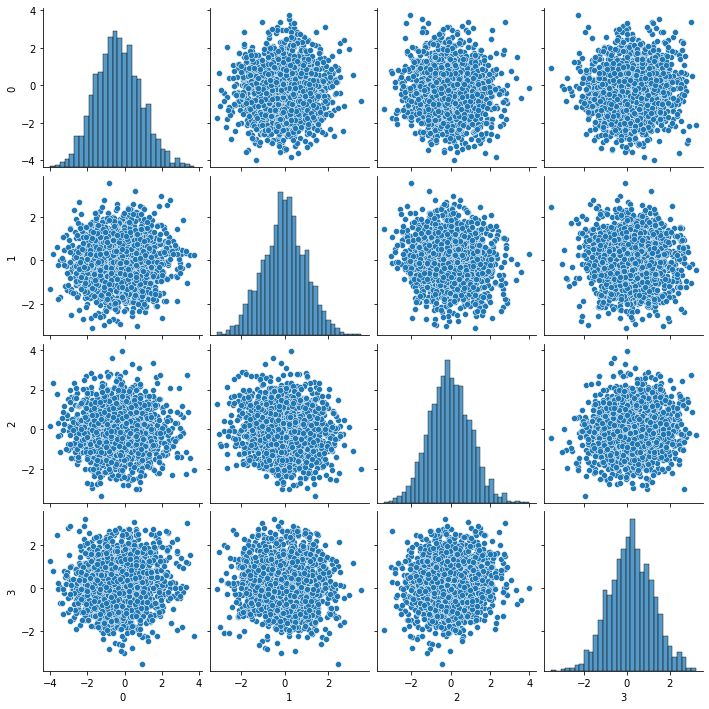

In [10]:
df = pd.DataFrame(q_samples[:, 0:4])
sns.pairplot(df)

Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

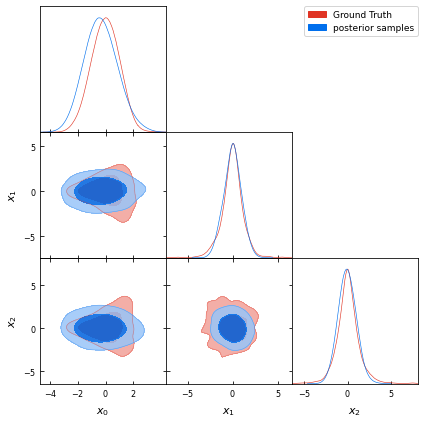

In [11]:
# First plot the samples without weights.
plot_triangles(q_samples[:,0:3], np.ones(len(q_samples)), truth_samples=x_prime[:,0:3], d=3,
              out_name='./dla_figs/funnel_100d_q_DLA_50.png')

In [12]:
def latent_mh_update_check(dla_samples, q_model, log_like=log_like, log_prior=log_flat_prior):
    '''
    This function should sanity check the MH acceptance procedure ...
    '''
    
    z_samples = q_model.forward(torch.tensor(np.asarray(dla_samples), dtype=torch.float32))
    z_samples = jnp.asarray(z_samples.detach().numpy())
    llk_current = jax.vmap(lambda x: log_like(x))(dla_samples)
    lpr_current = jax.vmap(lambda x: log_prior(x))(dla_samples)
    logp_current = llk_current + lpr_current
    logq_current = q_model.logq(torch.tensor(np.asarray(dla_samples), dtype=torch.float32))
    logq_current = logq_current.detach().numpy()
    logj_current = q_model.logj_forward(torch.tensor(np.asarray(dla_samples), dtype=torch.float32))
    logj_current = jnp.asarray(logj_current.detach().numpy())
    latent_logq_current = jax.scipy.stats.multivariate_normal.logpdf(z_samples,
                                                                     mean=jnp.zeros(100),
                                                                     cov=jnp.eye(100))
    latent_logp_current = llk_current + lpr_current - logj_current
    
    prop_samples = q_model.sample(len(dla_samples))
    prop_z_samples = q_model.forward(prop_samples)
    prop_logj = q_model.logj_forward(prop_samples)
    logq_prop = q_model.logq(prop_samples)
    logq_prop = jnp.asarray(logq_prop.detach().numpy())
    prop_samples = jnp.asarray(prop_samples.detach().numpy())
    prop_z_samples = jnp.asarray(prop_z_samples.detach().numpy())
    prop_logj = jnp.asarray(prop_logj.detach().numpy())
    llk_prop = jax.vmap(lambda x: log_like(x))(prop_samples)
    lpr_prop = jax.vmap(lambda x: log_prior(x))(prop_samples)
    logp_prop = llk_prop + lpr_prop
    latent_logp_prop = llk_prop + lpr_prop - prop_logj
    latent_logq_prop = jax.scipy.stats.multivariate_normal.logpdf(prop_z_samples,
                                                                  mean=jnp.zeros(100),
                                                                  cov=jnp.eye(100))
    
    log_alpha = latent_logp_prop + latent_logq_current - latent_logp_current - latent_logq_prop
    alpha = jnp.exp(log_alpha)
    alpha = jnp.clip(alpha, a_min=0, a_max=1)
    
    log_R = jnp.log(jax.random.uniform(jax.random.PRNGKey(0), shape=(len(prop_samples),),
                                       minval=0.0, maxval=1.0))
    accept = log_R < log_alpha
    print(len(accept[accept == True]))
    '''
    print(f'log_alpha = {log_alpha}')
    print(f'alpha = {alpha}')
    print(f'logp_current = {logp_current}')
    print(f'logq_current = {logq_current}')
    print(f'logp_prop = {logp_prop}')
    print(f'logq_prop = {logq_prop}')
    '''
    print(len(alpha[alpha==1]))

In [13]:
def mh_update_check(dla_samples, q_model, log_like=log_like, log_prior=log_flat_prior):
    
    llk_current = jax.vmap(lambda x: log_like(x))(dla_samples)
    lpr_current = jax.vmap(lambda x: log_prior(x))(dla_samples)
    logp_current = llk_current + lpr_current
    logq_current = q_model.logq(torch.tensor(np.asarray(dla_samples), dtype=torch.float32))
    logq_current = logq_current.detach().numpy()
    
    prop_samples = q_model.sample(len(dla_samples))
    logq_prop = q_model.logq(prop_samples)
    logq_prop = logq_prop.detach().numpy()
    prop_samples = jnp.asarray(prop_samples.detach().numpy())
    llk_prop = jax.vmap(lambda x: log_like(x))(prop_samples)
    lpr_prop = jax.vmap(lambda x: log_prior(x))(prop_samples)
    logp_prop = llk_prop + lpr_prop
    
    log_alpha = logp_prop + logq_current - logp_current - logq_prop
    alpha = jnp.exp(log_alpha)
    alpha = jnp.clip(alpha, a_min=0, a_max=1)
    
    log_R = jnp.log(jax.random.uniform(jax.random.PRNGKey(0), shape=(len(prop_samples),),
                                       minval=0.0, maxval=1.0))
    accept = log_R < log_alpha
    print(len(accept[accept == True]))
    '''
    print(f'log_alpha = {log_alpha}')
    print(f'alpha = {alpha}')
    print(f'logp_current = {logp_current}')
    print(f'logq_current = {logq_current}')
    print(f'logp_prop = {logp_prop}')
    print(f'logq_prop = {logq_prop}')
    '''
    print(len(alpha[alpha==1]))

In [14]:
def grad_dla_mh_adjustment(nf_model, dla_samples, log_like=log_like, log_prior=log_flat_prior,
                           beta=None):
    """MH adjustment for gradient-based DLA exploration."""
    if beta is None:
        beta = 1.0
        
    log_R = jnp.log(jax.random.uniform(jax.random.PRNGKey(0), shape=(len(dla_samples),),
                                       minval=0.0, maxval=1.0))

    q_samples_prop = nf_model.sample(len(dla_samples))
    logq_prop = nf_model.logq(q_samples_prop)
    q_samples_prop = jnp.asarray(q_samples_prop.detach().numpy())
    logq_prop = jnp.asarray(logq_prop.detach().numpy())
    
    likelihood_logp_prop = jax.vmap(lambda x: log_like(x))(q_samples_prop)
    prior_logp_prop = jax.vmap(lambda x: log_prior(x))(q_samples_prop)
    joint_logp_prop = beta * likelihood_logp_prop + prior_logp_prop
    
    likelihood_logp = jax.vmap(lambda x: log_like(x))(dla_samples)
    prior_logp = jax.vmap(lambda x: log_prior(x))(dla_samples)
    joint_logp = beta * likelihood_logp + prior_logp
    old_logq = nf_model.logq(torch.tensor(np.asarray(dla_samples), dtype=torch.float32))
    old_logq = jnp.asarray(old_logq.detach().numpy())

    log_proposal_ratio = joint_logp_prop + old_logq - joint_logp - logq_prop
    accepted = log_R < log_proposal_ratio
    acc_idx = jnp.where(accepted == True)[0]
    mh_adjust_acc_rate = len(acc_idx) / len(dla_samples)
    print(len(accepted[accepted == True]))
    print(f'Acceptance rate for MH adjustment: {mh_adjust_acc_rate}')

    dla_samples = dla_samples.at[acc_idx].set(dla_samples[acc_idx])
    
    return dla_samples

In [85]:
dla_samples = trace['dla_samples'][0]['DLA_101']
q_model = trace['dla_q_models'][0]['DLA_101']
mh_update_check(dla_samples, q_model)

23
19


In [86]:
latent_mh_update_check(dla_samples, q_model)

18
15


In [88]:
grad_dla_mh_adjustment(q_model, dla_samples)

1.0
20
Acceptance rate for MH adjustment: 0.02


In [90]:
for i in range(25):
    dla_samples = grad_dla_mh_adjustment(q_model, dla_samples)

15
Acceptance rate for MH adjustment: 0.015
10
Acceptance rate for MH adjustment: 0.01
16
Acceptance rate for MH adjustment: 0.016
19
Acceptance rate for MH adjustment: 0.019
21
Acceptance rate for MH adjustment: 0.021
17
Acceptance rate for MH adjustment: 0.017
14
Acceptance rate for MH adjustment: 0.014
11
Acceptance rate for MH adjustment: 0.011
14
Acceptance rate for MH adjustment: 0.014
17
Acceptance rate for MH adjustment: 0.017
16
Acceptance rate for MH adjustment: 0.016
15
Acceptance rate for MH adjustment: 0.015
14
Acceptance rate for MH adjustment: 0.014
15
Acceptance rate for MH adjustment: 0.015
12
Acceptance rate for MH adjustment: 0.012
12
Acceptance rate for MH adjustment: 0.012
10
Acceptance rate for MH adjustment: 0.01
15
Acceptance rate for MH adjustment: 0.015
15
Acceptance rate for MH adjustment: 0.015
13
Acceptance rate for MH adjustment: 0.013
13
Acceptance rate for MH adjustment: 0.013
20
Acceptance rate for MH adjustment: 0.02
13
Acceptance rate for MH adjustmen

In [15]:
plot_triangles(dla_samples[:, 0:3], np.ones(len(dla_samples)), truth_samples=x_prime[:,0:3], d=3)

NameError: name 'dla_samples' is not defined

Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

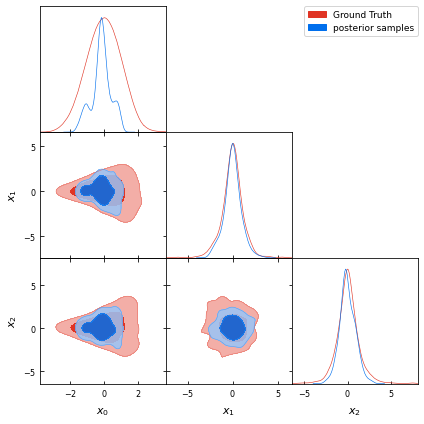

In [13]:
mh_samples = trace['mh_samples'][0]
dla_key= 'DLA_11'

np.savetxt(f'./fiducial_samples/funnel_100d_{dla_key}_samples.txt', mh_samples[dla_key])


plot_triangles(mh_samples[dla_key][:,0:3], np.ones(len(mh_samples[dla_key])), truth_samples=x_prime[:,0:3], d=3,
               out_name=f'./dla_figs/funnel_100d_dla_samples_{dla_key}.png')

<Figure size 432x288 with 0 Axes>

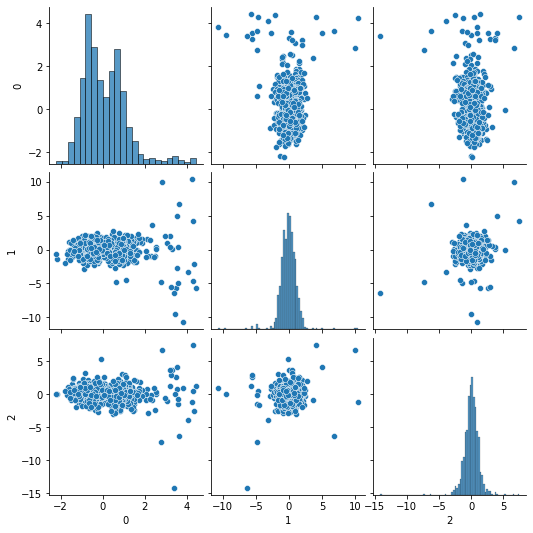

In [14]:
df = pd.DataFrame(mh_samples[dla_key][:,0:3])

plt.figure()
sns.pairplot(df)
plt.savefig(f'./dla_figs/funnel_100d_scatter_{dla_key}.png')

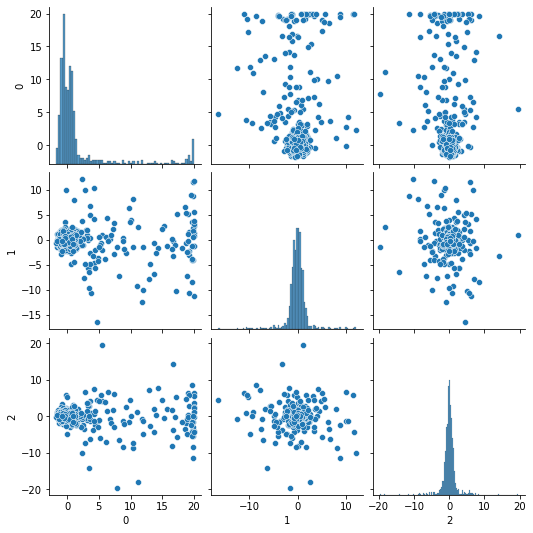

In [15]:
dla_samples = trace['dla_samples'][0]

df = pd.DataFrame(dla_samples[dla_key][:,0:3])
sns.pairplot(df)

In [95]:
diff = dla_samples[dla_key][:,0:3] - mh_samples[dla_key][:,0:3]

print(diff[:,0])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.08942747  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

Removed no burn in
Removed no burn in


MCSamplesError: Parameter range is <= 0: x0

<Figure size 432x288 with 0 Axes>

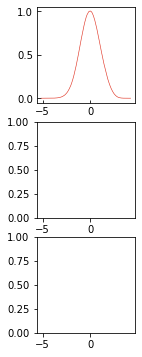

In [96]:
plot_triangles(q_samples[:,0:3], iw, truth_samples=x_prime[:,0:3], out_name='funnel_weight_CMH_loss3.png', 
               d=3)

In [97]:
q_models = trace['dla_q_models'][0]
q = q_models['DLA_101']

logq = q.logq(torch.tensor(np.asarray(dla_samples['DLA_101']), dtype=torch.float32))

prop = jnp.asarray(q.sample(1000).detach().numpy())
prop_logq = q.logq(torch.tensor(np.asarray(prop), dtype=torch.float32))
prop_logq, logq = jnp.asarray(prop_logq.detach().numpy()), jnp.asarray(logq.detach().numpy())

logp = jax.vmap(lambda x: log_like(x) + log_flat_prior(x))(dla_samples['DLA_101'])
prop_logp = jax.vmap(lambda x: log_like(x) + log_flat_prior(x))(prop)

alpha = prop_logp + logq - logp - prop_logq
accept_R = jnp.clip(jnp.exp(alpha), a_min=0, a_max=1)
#print(jnp.clip(jnp.exp(alpha), a_min=0, a_max=1))

accepted = dla_samples['DLA_101'][accept_R == 0.0]
#print(accepted[:, 0])

#print(prop_logq[accept_R == 0.0])

logw = logp - logq 
logw -= logsumexp(logw) - jnp.log(len(logw))

#print(logw)
k = 0.25
logw_clip = logsumexp(logw) + (k - 1.0) * jnp.log(len(logw))
#print(jnp.clip(logw, a_min=-jnp.inf, a_max=logw_clip))

clipped_logw = jnp.clip(logw, a_min=-jnp.inf, a_max=logw_clip)
print(jnp.exp(clipped_logw))

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.       

In [15]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

     labels     $x_0$     $x_1$
0         q -2.514441 -0.037992
1         q -1.765997  0.083429
2         q  0.276146 -0.810530
3         q -1.301102  0.472336
4         q -2.202765  1.417564
...     ...       ...       ...
1395      T -1.372386 -0.016664
1396      T  1.848067  0.656596
1397      T -0.869378  1.127895
1398      T -0.607013  0.840471
1399      T -0.836582 -0.199692

[1400 rows x 3 columns]


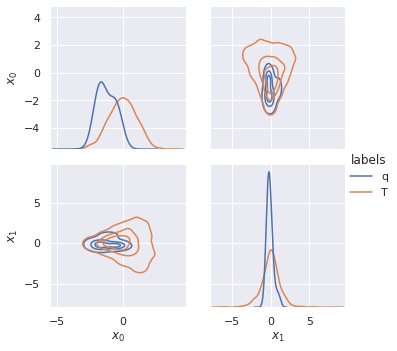

In [16]:
x_mala = trace['final_q_samples'][0]
f_w = trace['final_qw_weights'][0]


sns_pairplot(x_mala[:, 0:2], f_w, x_prime[:, 0:2], levels=4, 
             out_name='./dla_figs/funnel_100d_finalq_unweighted.png')

2000
2000
     labels     $x_0$     $x_1$
0         q -0.773878  0.876810
1         q -0.642967  0.787107
2         q -1.301809 -0.382772
3         q -0.067778 -0.076786
4         q  0.675739  1.864187
...     ...       ...       ...
2995      T -1.372386 -0.016664
2996      T  1.848067  0.656596
2997      T -0.869378  1.127895
2998      T -0.607013  0.840471
2999      T -0.836582 -0.199692

[3000 rows x 3 columns]


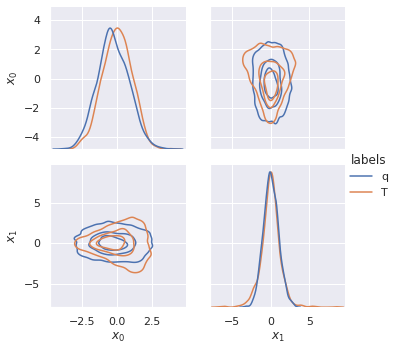

In [26]:
q_string = 'DLA_15'
qi = q_models[q_string]
q_samples = qi.sample(2000)
logq = qi.logq(q_samples)
q_samples = q_samples.detach().numpy()
logq = logq.detach().numpy()

llk = jax.vmap(lambda x: log_like(x))(jnp.asarray(q_samples))
lpr = jax.vmap(lambda x: log_flat_prior(x))(jnp.asarray(q_samples))
logw = llk + lpr - logq
logw = jnp.clip(logw, a_min=-jnp.inf, a_max=logsumexp(logw) - 0.75 * jnp.log(len(logw)))
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)
print(len(iw))
print(len(q_samples))

sns_pairplot(q_samples[:, 0:2], np.ones(len(iw)), x_prime[:, 0:2], levels=4,
             out_name=f'./dla_figs/funnel_100d_qfit_{q_string}.png')

     labels     $x_0$     $x_1$
0         q -1.847791  0.408338
1         q -1.516601  0.814532
2         q  0.502430  0.107834
3         q -1.882678 -0.072058
4         q -0.668993 -1.625223
...     ...       ...       ...
1395      T -1.372386 -0.016664
1396      T  1.848067  0.656596
1397      T -0.869378  1.127895
1398      T -0.607013  0.840471
1399      T -0.836582 -0.199692

[1400 rows x 3 columns]


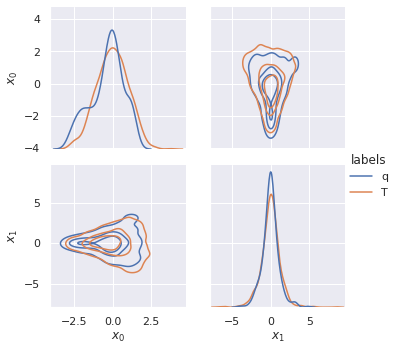

In [32]:
dla_samples = trace['dla_samples'][0]
dla_key = 'DLA_14'

logq = qi.logq(torch.tensor(np.asarray(dla_samples[dla_key]), dtype=torch.float32))
logq = logq.detach().numpy()
llk = jax.vmap(lambda x: log_like(x))(jnp.asarray(dla_samples[dla_key]))
lpr = jax.vmap(lambda x: log_flat_prior(x))(jnp.asarray(dla_samples[dla_key]))
logw = llk + lpr - logq
logw = jnp.clip(logw, a_min=-jnp.inf, a_max=logsumexp(logw) - 0.75 * jnp.log(len(logw)))
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

sns_pairplot(dla_samples[dla_key][:, 0:2], np.ones(len(iw)), x_prime[:, 0:2], levels=4,
             out_name='./dla_figs/funnel_100d_dla_samples_DLA_15_unweighted.png')

np.savetxt('./dla_figs/funnel_100d_dla_samples_DLA_15.txt', dla_samples[dla_key])

     labels     $x_0$     $x_1$     $x_2$     $x_3$
0         q  1.968785  4.890537 -3.017689  4.439617
1         q  1.154820  0.769178  0.207603 -0.811344
2         q  1.184865 -1.139364  2.181051 -2.411217
3         q  2.137444 -1.394255 -1.086983  0.322981
4         q -1.879152  0.344067 -0.059969  0.764830
...     ...       ...       ...       ...       ...
1451      T  1.225636 -4.514503 -1.698475 -1.114575
1452      T -1.225981  0.482753  0.161516 -0.594867
1453      T  0.842828  1.213534  2.927819  2.211231
1454      T  0.152172 -1.254186  0.258806  0.173583
1455      T  0.886611 -1.425746  1.439080 -1.680964

[1456 rows x 5 columns]


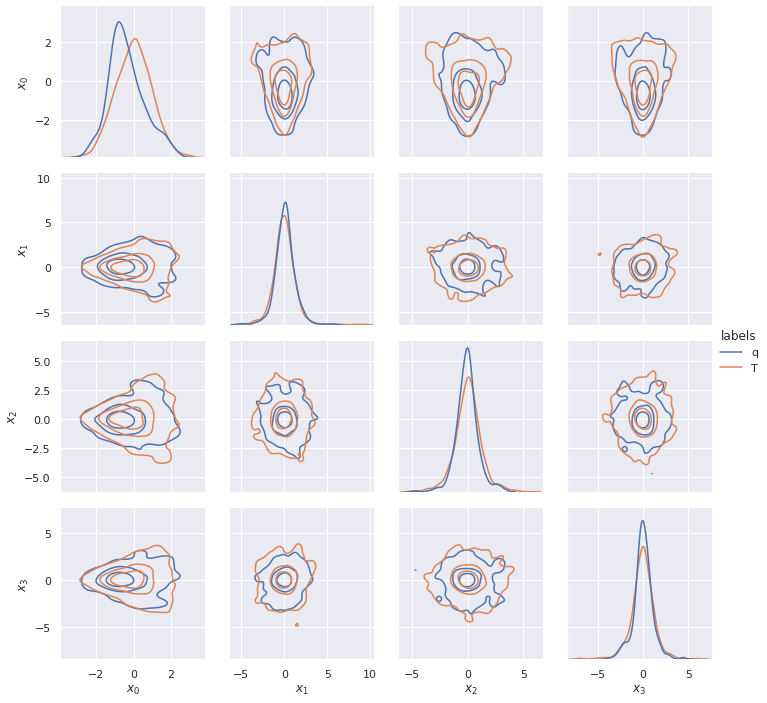

In [123]:
sns_pairplot(q_samples[max_cull_idx:, 0:4], np.ones(len(q_samples[max_cull_idx:, 0:4])), x_prime[:, 0:4], levels=4, 
             out_name='./dla_figs/funnel_100d_cullZ.png')

     labels     $x_0$     $x_1$     $x_2$     $x_3$
0         q -2.743546  0.357971  2.562327 -1.236784
1         q  3.182696 -2.248374  0.612011  1.967439
2         q  1.032429  0.056826 -0.266038 -1.501257
3         q  1.314948  4.304429  2.630910  1.852251
4         q  0.646222  4.774312  1.368743  0.811416
...     ...       ...       ...       ...       ...
2295      T  0.200663 -0.495774  1.286656 -0.212917
2296      T -0.358535  0.437187  0.453195  1.047625
2297      T -0.025528 -0.721077  1.711824  1.125372
2298      T  0.727651 -0.417952  1.464705 -2.825271
2299      T  0.143559  0.682592  0.017291 -1.370391

[2300 rows x 5 columns]


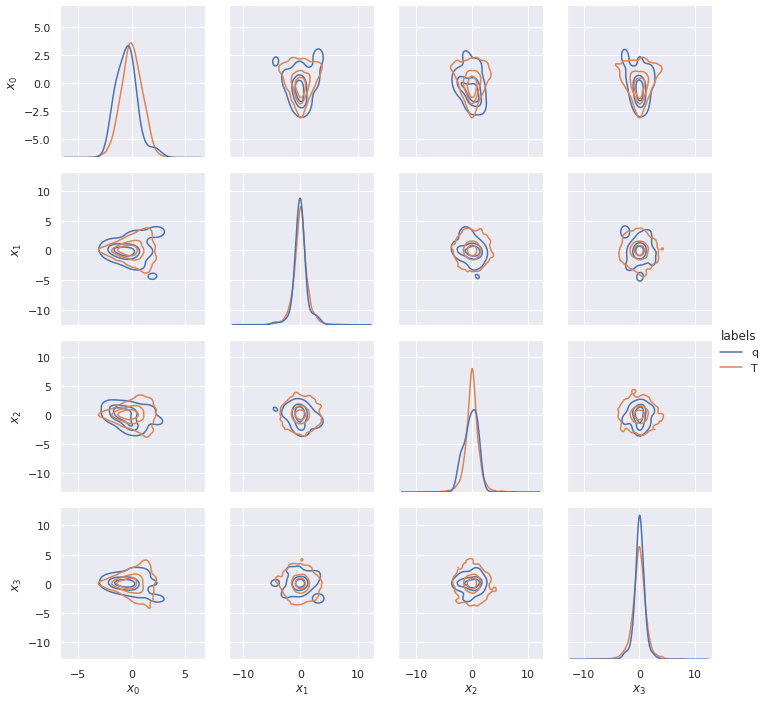

In [17]:
beta = 1

x_prime = np.random.normal(0, 1, size=(2000, D))
x_prime[:, 0] = x_prime[:, 0] * a / np.sqrt(beta)
x_prime[:, 1:] = x_prime[:, 1:] * np.exp(b * x_prime[:, 0]).reshape((2000, 1)) / np.sqrt(beta)

#for key in list(q_models.keys()):
for key in ['DLA_21']:

    # There were 10 temperature levels. q10_w corresponds to the q fit at beta=1 i.e. the target.
    qi = q_models[key]
    q_samples, logq = qi.sample(300, device='cpu')
    q_samples, logq = q_samples.numpy(), logq.numpy()
    iw = jax.vmap(lambda x: log_like(x))(q_samples)
    logp = jax.vmap(lambda x: log_like(x))(q_samples)
    logw = logp - logq
    logw -= logsumexp(logw)
    iw = np.exp(logw)
    iw /= np.sum(iw)
    
    sns_pairplot(q_samples[:, 0:4], iw, x_prime[:, 0:4], levels=4, 
                 out_name=f'./dla_figs/funnel_16d_{key}_20layers.png')